In [1]:
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")
import config_readwrite as crw
import fet
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# functions

In [2]:
def check_section(config, section):
    
    if config.has_section(section) is False:
        config.add_section(section)
        
    return config
def makeBed(lcl_csv, value):
    
    # make the .bed outfile
    lcl_bed = os.path.splitext(lcl_csv)[0] +".bed"
    d_ = pd.read_csv(lcl_csv)

    # make id
    id_col = f'{value}_id'
    d_[id_col] = d_["chr"] +":"+ d_["start"].map(str) +"-"+ d_["end"].map(str)

    # make smaller df
    d = d_[['chr', 'start', 'end', id_col]].drop_duplicates()

    # rename chr column w/ hash
    d.columns = ["#chr", "start", "end", id_col]
    
    # write bed
    d.to_csv(lcl_bed, sep='\t', index=False)
    
    ### map regulatory states to ids

    lcl_states = d_[[id_col,"regulatory_state"]].drop_duplicates().copy()
    lcl_states.columns = [id_col, "label"]
    
    return lcl_bed, lcl_states

# liftOver rheMac8 -> hg38

def liftOverSetUp(value, infile_bed):
    BIN = "/dors/capra_lab/users/fongsl/tools/evo/liftover_bed.py"
    TO = "Hg38"

    print(os.path.splitext(infile_bed)[0] + f".liftOver.to.{TO}.bed")
    OUT_BED = os.path.splitext(infile_bed)[0] + f".liftOver.to.{TO}.bed"
    
    FROM = value.split(".")[1]
    
    cmd= ["python", 
          BIN,
          infile_bed,
          FROM,
          TO
         ]
    
    print(" ".join(cmd))
    #if os.path.exists(OUT_BED) is False:
        #os.system(" ".join(cmd))
        
    return OUT_BED
def pbtInt(a, b, out):
    
    A, B = pbt.BedTool(a), pbt.BedTool(b)
    
    C = A.intersect(B, wao=True, output=out)
    
    print(f"bedtools intersect -a {a} -b {b} -wao > {out}")
    
    #return C

def openDfs(out, outshuf, lcl_state, value_name):
    names = ["#chr", "start", "end", "region_id", 
             f"chr_{value_name}.hg38", 
             f"start.{value_name}.hg38", 
             f"end.{value_name}.hg38", 
             f'{value_name}_id', "len"
            ]
    # open intersections

    df_ = pd.read_csv(out, sep='\t', header=None, 
                     names=names).drop_duplicates()
    
    df = pd.merge(df_, lcl_state, how="left")
    print(df.shape)

    validation_annots = df["label"].unique()
    
    ## shuffles

    # open shuffles
    shuf_ = pd.read_csv(out_shuf, sep='\t', header=None, 
                     names=names).drop_duplicates()
    shuf = pd.merge(shuf_, lcl_state, how="left")
    print(shuf.shape)

    return df, shuf, validation_annots

def compute2x2(col_list, annot, validation_annots, enrichment_col, df, shuf):
    
    """
    compute 2x2 FET + FDR correction for a specific MM/HH annotation and enrichment annotation
    
    input
        col_list (list) - list of region annotations (HH, MM, Cis | trans regions) to test for overlap 
        annot (pandas df) - pandas dataframe with all HH/MM region annotations
        validation annotations (list) - list of str w 
                                    identity of value in column to test for 
                                    (e.g. strong promoter, weak promoter, etc)
        enrichment_col (str) - column in df with validation annotations
        df (pd dataframe) - dataframe with atac-starr overlaps annotated
        shuf (pd dataframe) - dataframe with shuffled atac-starr element overlaps annotated
        
    method 
        1. make empyt dictionary to collect results
        2. get region ids for col (HH, MM , conserved active, etc.)
        3. get the number of overlaps in the test, shuffle dataframes. These are mutually exclusive
        4. per validation annotation, as long as value is not none or zero, compute 2x2
        5. compute 2x2
        6. annotate raw results of 2x2, add to collectiondictionary 
        7. after computing all results, perform FDR correction (alpha = 5%) 
        8. compute fraction of overlap
        
    Return
        fdr_res (pd dataframe) - dataframe of FDR corrected results
        
        
    """
    
    #1
    collection={}
    
    # compute 2x2
    for col in col_list:
        #2 get the region_ids that are HH/MM active
        pos = annot.loc[annot[col]==1, "region_id"]
         
        #3 get dataset and matched shuffle ids
        test = df.loc[df["region_id"].isin(pos)]
        test_shuf = shuf.loc[shuf["region_id"].isin(pos)]

        #4 per annotation (e.g. DELS, PELS, etc.)
        for a in validation_annots:
            if type(a) is str:
                a=a.split()
            a_str="_".join(a)
                

            # within set, how many elements have annotation, or don't.
            in_annot = test.loc[test[enrichment_col].isin(a)].shape[0] +1
            out_annot = test.loc[~test[enrichment_col].isin(a)].shape[0] +1

            # and in the shuffles?
            inshuf_annot = test_shuf.loc[test_shuf[enrichment_col].isin(a)].shape[0]+1
            outshuf_annot = test_shuf.loc[~test_shuf[enrichment_col].isin(a)].shape[0]+1

            #5 do 2x2
            result = fet.get_2x2(in_annot, out_annot, 
                                 inshuf_annot,outshuf_annot, 
                                 f"regions_x_shuf_{col}.{a_str}")
            #6
            result["col"], result[f"reg_annot"] = col, a_str
            result["n_pos_overlap"] = len(set(test.loc[test.len>0, "region_id"])) # the number of positions that overlap any annotation
            key_=a_str+"."+col

            print(key_)

            collection[key_] = result

    #7 FDR correction per shuffle, per test in dictionary (in this case, one dataset in dict)
    fdr_res = fet.fdr_correction(collection)

    #8 fraction of annotations 
    fdr_res["frac"] = fdr_res["a"]/(fdr_res["a"]+fdr_res["b"])
    fdr_res["frac_shuf"] = fdr_res["c"]/(fdr_res["c"]+fdr_res["d"])
    
    return fdr_res

def orderIndex(hue_order):
    
    # this index order was determined by high to low fraction of overlap in each dataset. 
    # ae is ambigous results between replicates
    index_order =['sP', 'sE',
                  'pP', 'pE', 
                   'wP','wE', 
                  'P/E', 'aP','aE',
                  'P/Non-re', 'E/Non-re'
                 ]

    final_order = []
    
    for h in hue_order:
        for i in index_order:
            final_order.append((h,i))
    return final_order

def reindexForPlotting(x, hue, data, hue_order):
     # indexing hell
    final_order = orderIndex(hue_order)  # another function to set index
    data= data.set_index([hue,x])  # micro, macro grouping order matters for reindexing
    data=data.reindex(final_order).reset_index()
    
    return data # indexed w/ orderIndex function

# config

In [3]:
cfn = os.path.join(os.path.dirname(os.getcwd()), "config")
config, cfn = crw.read_config(cfn)

## read

# read
BED = config["CIS_TRANS"]["regions"]
ANNOT = config["CIS_TRANS"]["regions_annotations"]
SHUF=config["SHUFFLES"]["shuf-all"]

## write

In [4]:
species_dict={"MM_LCL":"MM.rheMac8",
             "HH_LCL":"HH.hg38",
              "PT_LCL":"PT.panTro5",
              "GG_LCL":'GG.gorGor4',
              "PA_LCL":"PA.ponAbe2"
             }

section = 'garcia_perez'
config = check_section(config, section)

RE = f"/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/{section}"
PATH = "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/"

if os.path.exists(RE) is False:
    os.mkdir(RE)
config[section]["results"] = RE
config[section]["path"] = PATH

datasets = {}
for key, value in species_dict.items():
    
    # super enhancer element, super enhancer, and typical enhancer files
    LCL_CSV = os.path.join(PATH, f"{value}.garcia.perez.csv")
    
    # make bed
    LCL_BED, labels = makeBed(LCL_CSV, value)
    
    # liftover
    if key !="HH":
        LCL_BED_LIFT = liftOverSetUp(value, LCL_BED)

    else:  # don't liftOver HH
        LCL_BED_LIFT = LCL_BED
    
    #write
    config[section][key] = LCL_CSV
    config[section][f"{key}_BED"] = LCL_BED
    config[section][f"{key}_BED_LIFT"] = LCL_BED_LIFT
    datasets[key] = [LCL_BED_LIFT, labels]
crw.write(config, cfn)

/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/MM.rheMac8.garcia.perez.liftOver.to.Hg38.bed
python /dors/capra_lab/users/fongsl/tools/evo/liftover_bed.py /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/MM.rheMac8.garcia.perez.bed rheMac8 Hg38
/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/HH.hg38.garcia.perez.liftOver.to.Hg38.bed
python /dors/capra_lab/users/fongsl/tools/evo/liftover_bed.py /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/HH.hg38.garcia.perez.bed hg38 Hg38
/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/PT.panTro5.garcia.perez.liftOver.to.Hg38.bed
python /dors/capra_lab/users/fongsl/tools/evo/liftover_bed.py /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/PT.panTro5.garcia.perez.bed panTro5 Hg38
/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/garcia_perez_2021/GG.gorGor4.garcia.perez.liftOver.to.Hg38.bed
python /dors/capra_lab/

# intersection

In [5]:
intersections = {}
for name, value in datasets.items():

    dataset, lcl_label = value
    value_name = species_dict[name]
    
    out = os.path.join(RE, f"regions.x.{name}.bed")
    out_shuf = os.path.join(RE, f"shuf.regions.x.{name}.bed")
    
    print(out)
    config[section][f"regions_x_{name}"] = out
    config[section][f"shufregions_x_{name}"] = out_shuf
    if os.path.exists(out) is False:
        C = pbtInt(BED, dataset, out)

    
    if os.path.exists(out_shuf) is False:
        C = pbtInt(SHUF, dataset, out_shuf)

    # open the intersections
    df, shuf, validation_annots = openDfs(out, out_shuf, lcl_label, value_name)
    
    intersections[name] = [df, shuf, validation_annots]
    
crw.write(config, cfn)

/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/regions.x.MM_LCL.bed
(16912, 10)
(169232, 10)
/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/regions.x.HH_LCL.bed
(16897, 10)
(168970, 10)
/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/regions.x.PT_LCL.bed
(17003, 10)
(169913, 10)
/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/regions.x.GG_LCL.bed
(16923, 10)
(169055, 10)
/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/regions.x.PA_LCL.bed
(17071, 10)
(169764, 10)


In [6]:
df.head()

,#chr,start,end,region_id,chr_PA.ponAbe2.hg38,start.PA.ponAbe2.hg38,end.PA.ponAbe2.hg38,PA.ponAbe2_id,len,label
0,chr1,959034,959154,chr1:959034-959154,.,-1,-1,.,0,NaN
1,chr1,1002089,1002179,chr1:1002089-1002179,.,-1,-1,.,0,NaN
2,chr1,1064140,1064260,chr1:1064140-1064260,.,-1,-1,.,0,NaN
3,chr1,1214948,1215208,chr1:1214948-1215208,chr1,1213386,1216123,chr1:229371800-229374600,260,sE
4,chr1,1215328,1215508,chr1:1215328-1215508,chr1,1213386,1216123,chr1:229371800-229374600,180,sE


# review results

## annots

In [7]:
annot = pd.read_csv(ANNOT, sep='\t')
annot.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# Enrichments 

                                cCRE annot+     cCRE annot- 
                    HH_active    A               B
    matched_shuffle HH_active    C               D

## dictionary of enrichment tests to run

In [8]:
# name: [cols]
# cols == hue_order

analyses_dict={
     "species.specific":["conserved_active.regions",
                        "MM_active", 'HH_active'],
     # both these groups have conserved active in them

}
"""
   
    "species.active":['MM_active','HH_active']
    "conserved_active":["conserved_active.regions"],
    
    "HH.specific":["conserved_active.regions",
                    'HH-active_MM-inactive_cis-only',
                    'HH-active_MM-inactive_trans-only',
                    'HH-active_MM-inactive_cis+trans'],

    "MM.specific":["conserved_active.regions",
                    'MM-active_HH-inactive_cis-only',
                    'MM-active_HH-inactive_trans-only',
                    'MM-active_HH-inactive_cis+trans']
"cis_trans":["conserved_active.regions",
    'HH-active_MM-inactive_cis-only',
    'MM-active_HH-inactive_cis-only',
    'HH-active_MM-inactive_trans-only',
    'MM-active_HH-inactive_trans-only',
    'HH-active_MM-inactive_cis+trans',
    'MM-active_HH-inactive_cis+trans']
"""


'\n   \n    "species.active":[\'MM_active\',\'HH_active\']\n    "conserved_active":["conserved_active.regions"],\n    \n    "HH.specific":["conserved_active.regions",\n                    \'HH-active_MM-inactive_cis-only\',\n                    \'HH-active_MM-inactive_trans-only\',\n                    \'HH-active_MM-inactive_cis+trans\'],\n\n    "MM.specific":["conserved_active.regions",\n                    \'MM-active_HH-inactive_cis-only\',\n                    \'MM-active_HH-inactive_trans-only\',\n                    \'MM-active_HH-inactive_cis+trans\']\n"cis_trans":["conserved_active.regions",\n    \'HH-active_MM-inactive_cis-only\',\n    \'MM-active_HH-inactive_cis-only\',\n    \'HH-active_MM-inactive_trans-only\',\n    \'MM-active_HH-inactive_trans-only\',\n    \'HH-active_MM-inactive_cis+trans\',\n    \'MM-active_HH-inactive_cis+trans\']\n'

## file to write enrichments to

In [9]:
ENRICHMENTS = os.path.join(RE, "primate_LCL.OR.Frac.tsv")
ENRICHMENTS

'/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/garcia_perez/primate_LCL.OR.Frac.tsv'

In [10]:
if os.path.exists(ENRICHMENTS) is False:
    analyses_res = {}

    for name, cols in analyses_dict.items():
        print(name)
        if name not in analyses_res.keys():
            fdr_results={}
            for key, values, in intersections.items():

                df, shuf, validation_annots = values

                # override validation annotations - Don't test for ambiguous or uncertain calls. 
                validation_annots = ['sE', 'sP', 'wE', 'pP', 'wP', 'pE', 
                                     ['sE', 'sP', 'wE', 'pP', 'wP', 'pE'], 
                                    ['sP', 'pP', 'wP'], 
                                    ['sE',  'wE', 'pE']
                                    ]
                fdr_res = compute2x2(cols, annot, validation_annots, "label", df, shuf)

                fdr_res["sample"] = key
                fdr_results[key]=fdr_res

            fdr_res = pd.concat(fdr_results.values()).reset_index()

            ### clean up and annotate

            fdr_res.sort_values(by="frac", ascending=False).drop_duplicates()
            fdr_res["col2"] = fdr_res["col"] +"."+ fdr_res["sample"]

            # scientific notatio for FDRP value
            fdr_res["FDR_P2"]= fdr_res["FDR_P"].apply(lambda x: "{:.1E}".format(x))
            analyses_res[name]= fdr_res

    res = pd.concat(analyses_res.values())
    res_cols =[
        'comparison',
        'col',
        'reg_annot',
        'sample',
        'frac',
        'OR',
        'FDR_P',
        'index',
        'a',
        'b',
        'c',
        'd',
        'P',
        'ci_lower',
        'ci_lower_diff',
        'ci_upper',
        'ci_upper_diff',
        'OR_log2',
        'ci_lower_log2',
        'ci_upper_log2',
        'n_pos_overlap',
        'reject_null',
        'asterisks',
        '-log10p',
        'frac_shuf',
        'col2',
        'FDR_P2']
    res[res_cols].to_csv(ENRICHMENTS, sep='\t', index=False)

else:
    res=pd.read_csv(ENRICHMENTS, sep='\t')

species.specific
[[207, 2832], [2629, 27759]]
regions_x_shuf_conserved_active.regions.sE [[207, 2832], [2629, 27759]] 0.7717743261277408 0.0004315947706677759
sE.conserved_active.regions
[[1272, 1767], [5982, 24406]]
regions_x_shuf_conserved_active.regions.sP [[1272, 1767], [5982, 24406]] 2.936978450915849 6.541345109635516e-153
sP.conserved_active.regions
[[97, 2942], [2222, 28166]]
regions_x_shuf_conserved_active.regions.wE [[97, 2942], [2222, 28166]] 0.4179363891521715 1.1280253541521936e-20
wE.conserved_active.regions
[[38, 3001], [1404, 28984]]
regions_x_shuf_conserved_active.regions.pP [[38, 3001], [1404, 28984]] 0.26140194484079854 1.18293031112198e-23
pP.conserved_active.regions
[[6, 3033], [210, 30178]]
regions_x_shuf_conserved_active.regions.wP [[6, 3033], [210, 30178]] 0.28428241722010267 0.00032984110759581246
wP.conserved_active.regions
[[20, 3019], [2551, 27837]]
regions_x_shuf_conserved_active.regions.pE [[20, 3019], [2551, 27837]] 0.07229010465406015 8.420629177640731e-

regions_x_shuf_HH_active.sP_pP_wP [[5016, 4942], [37549, 62013]] 1.6762513978901374 1.1166790409189184e-131
sP_pP_wP.HH_active
[[1574, 8384], [22010, 77552]]
regions_x_shuf_HH_active.sE_wE_pE [[1574, 8384], [22010, 77552]] 0.6614947751022262 3.101100082677383e-51
sE_wE_pE.HH_active
[[289, 2772], [3357, 27164]]
regions_x_shuf_conserved_active.regions.sE [[289, 2772], [3357, 27164]] 0.8436202529142655 0.007999564544041144
sE.conserved_active.regions
[[1828, 1233], [8777, 21744]]
regions_x_shuf_conserved_active.regions.sP [[1828, 1233], [8777, 21744]] 3.67287760229332 2.647955903255857e-249
sP.conserved_active.regions
[[61, 3000], [1986, 28535]]
regions_x_shuf_conserved_active.regions.wE [[61, 3000], [1986, 28535]] 0.29215088956025514 1.4993467704665428e-29
wE.conserved_active.regions
[[35, 3026], [2040, 28481]]
regions_x_shuf_conserved_active.regions.pP [[35, 3026], [2040, 28481]] 0.16148202506382592 2.0039425434501682e-47
pP.conserved_active.regions
[[22, 3039], [498, 30023]]
regions_x_

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


regions_x_shuf_conserved_active.regions.sP [[1727, 1315], [7826, 22539]] 3.78234713381057 3.117731305389876e-256
sP.conserved_active.regions
[[32, 3010], [1411, 28954]]
regions_x_shuf_conserved_active.regions.wE [[32, 3010], [1411, 28954]] 0.2181549335901354 1.88192427093349e-27
wE.conserved_active.regions
[[7, 3035], [782, 29583]]
regions_x_shuf_conserved_active.regions.pP [[7, 3035], [782, 29583]] 0.08725188234451434 7.710173071718402e-24
pP.conserved_active.regions
[[24, 3018], [727, 29638]]
regions_x_shuf_conserved_active.regions.wP [[24, 3018], [727, 29638]] 0.3241951318225448 1.9953029787220973e-10
wP.conserved_active.regions
[[3, 3039], [233, 30132]]
regions_x_shuf_conserved_active.regions.pE [[3, 3039], [233, 30132]] 0.12766227878777608 6.2894305913834e-07
pE.conserved_active.regions
[[1979, 1063], [13540, 16825]]
regions_x_shuf_conserved_active.regions.sE_sP_wE_pP_wP_pE [[1979, 1063], [13540, 16825]] 2.31339044898152 1.0464317288850787e-103
sE_sP_wE_pP_wP_pE.conserved_active.r

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


regions_x_shuf_conserved_active.regions.sP [[1491, 1593], [6238, 24258]] 3.639749448885363 4.7424395001706865e-232
sP.conserved_active.regions
[[60, 3024], [1353, 29143]]
regions_x_shuf_conserved_active.regions.wE [[60, 3024], [1353, 29143]] 0.42737186029868957 7.963301065962243e-13
wE.conserved_active.regions
[[8, 3076], [680, 29816]]
regions_x_shuf_conserved_active.regions.pP [[8, 3076], [680, 29816]] 0.11403656391034958 2.882405997464444e-19
pP.conserved_active.regions
[[32, 3052], [360, 30136]]
regions_x_shuf_conserved_active.regions.wP [[32, 3052], [360, 30136]] 0.8777049657783603 0.5381984496008647
wP.conserved_active.regions
[[3, 3081], [595, 29901]]
regions_x_shuf_conserved_active.regions.pE [[3, 3081], [595, 29901]] 0.04893260127809644 5.2988957224758576e-21
pE.conserved_active.regions
[[1813, 1271], [11440, 19056]]
regions_x_shuf_conserved_active.regions.sE_sP_wE_pP_wP_pE [[1813, 1271], [11440, 19056]] 2.376063118628028 2.787023082089823e-114
sE_sP_wE_pP_wP_pE.conserved_activ

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
active_groups = {"species":
                 ['conserved_active.regions', "MM_active", 'HH_active'],
                "HH-active": 
                         ['HH-active_MM-inactive_cis+trans',
                    'HH-active_MM-inactive_cis-only',
                    'HH-active_MM-inactive_trans-only'], 
                "MM-active":
                         ['MM-active_HH-inactive_cis+trans',
                    'MM-active_HH-inactive_cis-only',
                    'MM-active_HH-inactive_trans-only',], 
        }

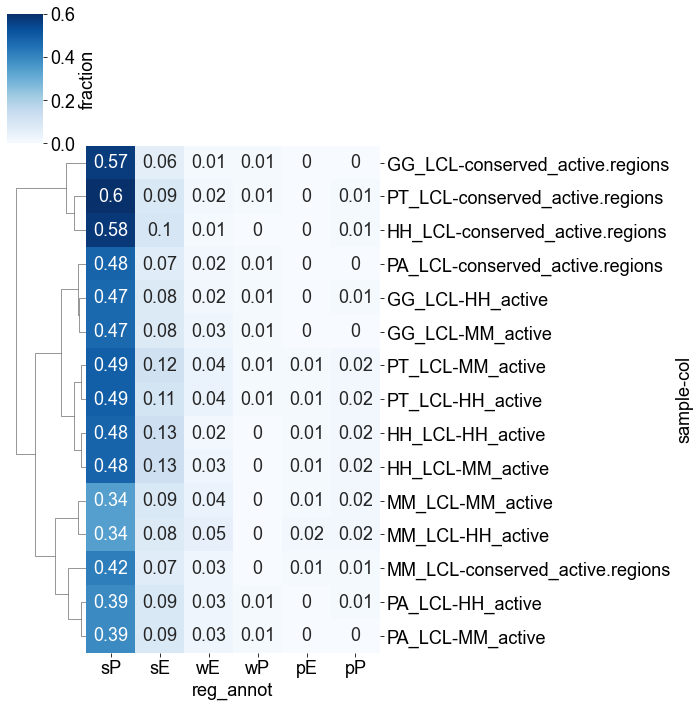

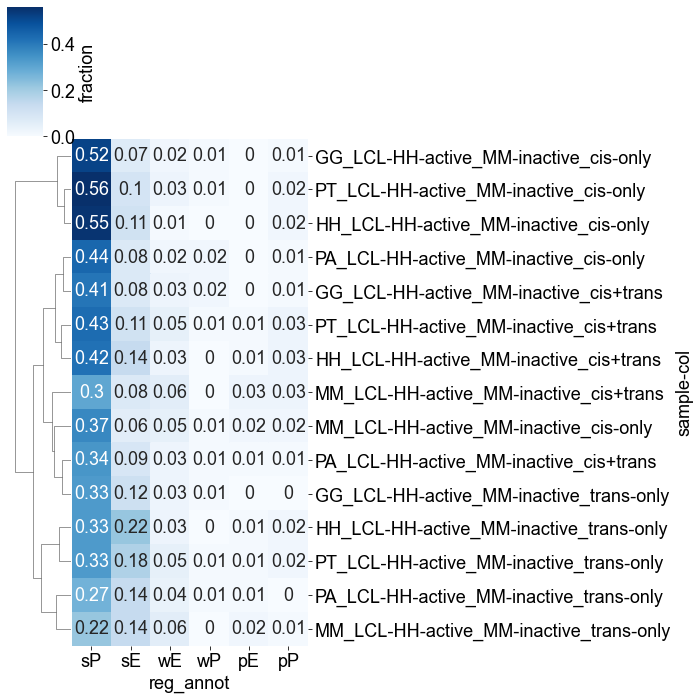

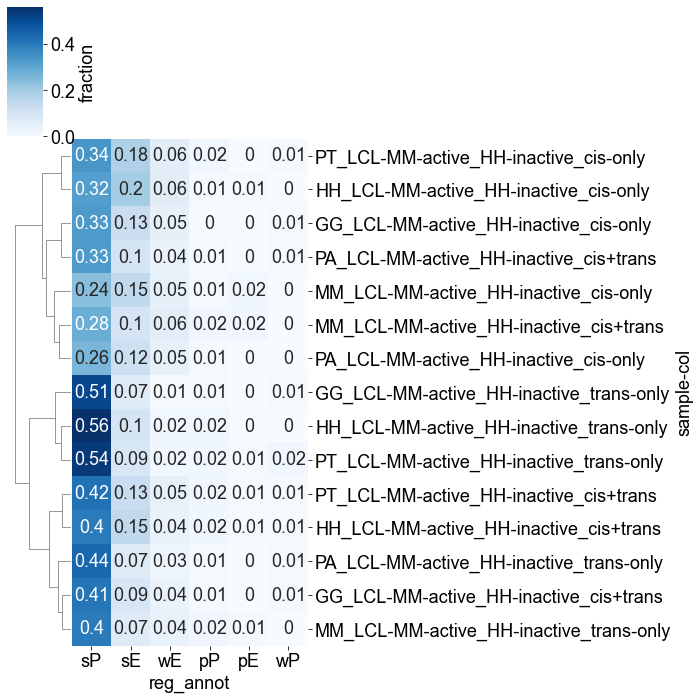

In [65]:
fdr_res = res.copy()

col = "frac"
validation_annots = ['sE', 'sP', 'wE', 'pP', 'wP', 'pE']
fdr_res[col] = fdr_res[col].round(2)

for name, keep_cols in active_groups.items():

    # keep only specific information for plotting
    t = fdr_res.loc[fdr_res["col"].isin(keep_cols) &
                    fdr_res["reg_annot"].isin(validation_annots), 
                    ["col", "sample", 'reg_annot', col]].drop_duplicates()
    
    # pivot table
    table = pd.pivot(t, index=[ "sample","col", ], columns="reg_annot", values=col)
    
    # plot table of fractions as heatmap
    #fig, ax =plt.subplots(figsize=(10,10))
    cg = sns.clustermap(table.sort_values(by = ["sP", "sE"], ascending =False), cmap="Blues", 
                annot =True, 
                square=True,
                cbar_kws={"label": f"fraction"}
               )
    
    #cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    ax.set(xlabel="", 
          ylabel = "primate_LCL-AtacStarr_group")
    out=os.path.join(RE, f"primate.LCL_Frac-{name}.pdf")
    plt.savefig(out, bbox_inches="tight")
    plt.show()
